In [24]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=100
IMAGE_HEIGHT=450  # Training images are 600x450
IMAGE_WIDTH=600

In [4]:
# Retrieve dataset images from directory

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Train",
    shuffle=True,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE
)

Found 2123 files belonging to 9 classes.


In [5]:
class_names = dataset.class_names

In [6]:
# Partition the dataset into training, validation, test sets
# 80% ==> training
# 20% ==> 10% validation, 10% test

def get_dataset_partitions_tf(
    ds, train_split=0.7,
    val_split=0.15,
    test_split=0.15,
    shuffle=True,
    shuffle_size=10_000
):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [7]:
# Call the partitioning function to fetch split datasets

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
len(train_ds)

46

In [9]:
len(val_ds)

10

In [10]:
len(test_ds)

11

In [11]:
# Save each dataset in memory to improve pipeline performance.
# Shuffle and prefetch to load the next set from disk storage
# to further improve processor performance when reading images.

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
# Image preprocessing pipeline

# Resize and rescale layer to normalize image sizes.

resize_and_rescale = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
        layers.experimental.preprocessing.Rescaling(1.0/255)
    ]
)

In [13]:
# Data augmentation layer to allow training to be conducted
# against multiple versions of each image, improving performance
# and accuracy of model predictions.

data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2)
    ]
)

In [14]:
# Convolutional Neural Network model (CNN)
# Define the convolutional layer using Tensorflow Conv2D library
# The CNN applies different filters.
#
# Conv2D arguments:
#     1. filters (number of layers/edges used for detection)
#     2. kernel size ("size of filter", ex: 3x3 matrix -> (3,3))
#     3. activation layer ("relu" computes quickly)
#     4. input shape (dimensions of input image size)
#
# Pooling layer
#     1. takes reduction of kernel size as argument (ex: (2,2))
#     2. reduces size of image matrix to aid computation
#     3. layer is flattened into a single layer of 9 neurons (num classes=9)
#     4. apply "softmax" activation normalizes the probability of classes

input_shape = (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)
num_classes = 9

model = models.Sequential(
    [
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ]
)

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 450, 600, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 450, 600, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 448, 598, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 224, 299, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 222, 297, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 111, 148, 32)       0         
 2D)                                                  

In [24]:
# Compile CNN model using "adam" optimizer

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
# Train the model for a fixed number of epochs (iterations on a dataset)
# Takes a long time, depending on CPU/GPU processor capacity and number
# of iterations (epochs), etc.

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/100
46/46 [==============================] - 272s 5s/step - loss: 2.0454 - accuracy: 0.1999 - val_loss: 1.9680 - val_accuracy: 0.2943
Epoch 2/100
46/46 [==============================] - 238s 5s/step - loss: 1.9005 - accuracy: 0.2977 - val_loss: 1.8136 - val_accuracy: 0.3278
Epoch 3/100
46/46 [==============================] - 234s 5s/step - loss: 1.8387 - accuracy: 0.3150 - val_loss: 1.7666 - val_accuracy: 0.3512
Epoch 4/100
46/46 [==============================] - 234s 5s/step - loss: 1.7909 - accuracy: 0.3370 - val_loss: 1.8518 - val_accuracy: 0.3110
Epoch 5/100
46/46 [==============================] - 235s 5s/step - loss: 1.7604 - accuracy: 0.3425 - val_loss: 1.6931 - val_accuracy: 0.3378
Epoch 6/100
46/46 [==============================] - 236s 5s/step - loss: 1.7023 - accuracy: 0.3811 - val_loss: 1.7672 - val_accuracy: 0.3579
Epoch 7/100
46/46 [==============================] - 203s 4s/step - loss: 1.6251 - accuracy: 0.4218 - val_loss: 1.6338 - val_accuracy: 0.3913
Epoch 

In [27]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 46}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
# Plot training and validation accuracy and loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [1]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'plt' is not defined

first image to predict
actual label: melanoma
[0.11049251 0.11292306 0.11317137 0.11133759 0.10730843 0.11034879
 0.11062086 0.11408032 0.10971706]
0.11408032
7
predicted label: squamous cell carcinoma


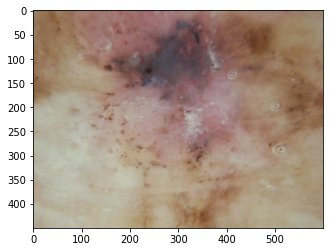

In [28]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    # Show predicted probability of class
    # argmax selects index of class with highest value
    # print the class name, this is the class for the prediction

    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print(max(batch_prediction[0]))
    print(np.argmax(batch_prediction[0]))
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [30]:
def predict(model, img):
    # Convert image into image array and create a batch out of it
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())  
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

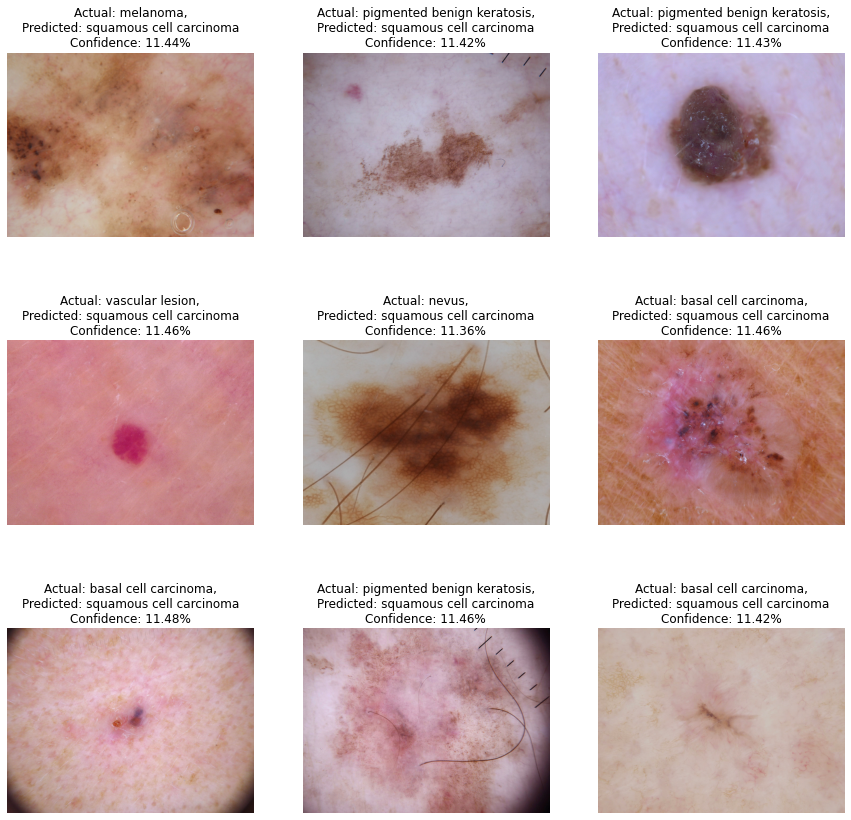

In [31]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")

In [39]:
# Save to models directory with timestamped version
now = datetime.datetime.now()
model_version = now.strftime("Model@%Y-%m-%d::%H:%M:%S")

model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/Model@2022-05-17::08:34:06/assets


In [41]:
# Save model in HDF5 format for cloud deployment
model.save(f"../saved_models/{model_version}.h5")